# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_current = [inp_cur1]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes = [out_spikes1]

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel2', clean=False)

In [8]:
n_opt = NevergradOptimizer('DE')
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=100,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory=2*ms,
                     )

exponential_euler


In [10]:
result_dict, error = fitter.fit(n_rounds=60,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 2.2],
                                a = [0.01, 0.1],
                                R = [1, 15] * 1/nA, 
                                tau = [7, 20]*ms,
                                taut = [30, 100]*ms,
                               )

Round 0: fit (11740694001.834238, 0.09311611985405749, 0.0557482561703271, 0.9291236135518912, 0.01099186585409641) with error: 0.041230712631993904
Round 1: fit (9215353169.32779, 0.0956360553230644, 0.05103213080375908, 0.5876599495725626, 0.01092478490740864) with error: 0.041230712631993904
Round 2: fit (13507006358.618681, 0.09217967071305214, 0.03935315252158232, 0.7672604178153632, 0.015061479674868098) with error: 0.014859934066894565
Round 3: fit (13507006358.618681, 0.09217967071305214, 0.03935315252158232, 0.7672604178153632, 0.015061479674868098) with error: 0.014859934066894565
Round 4: fit (13735209362.858198, 0.09126437140079975, 0.018085796390135855, 0.9001083777336685, 0.013612526958680461) with error: 0.0008884778590291242
Round 5: fit (13735209362.858198, 0.09126437140079975, 0.018085796390135855, 0.9001083777336685, 0.013612526958680461) with error: 0.0008884778590291242
Round 6: fit (13735209362.858198, 0.09126437140079975, 0.018085796390135855, 0.9001083777336685,

In [11]:
result_dict

{'R': 13947551733.983437,
 'taut': 0.07206368639150168,
 'a': 0.016126816497248384,
 'alpha': 1.2529700208379744,
 'tau': 0.013078603485893162}

In [12]:
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', result_dict['R'])
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', result_dict['alpha'])

a 0.016126816497248384
tau 13.07860349 ms
R 13947551733.983437
taut 72.06368639 ms
alpha 1.2529700208379744


In [13]:
error

0.0008003211224654194

In [14]:
1 - error

0.9991996788775346

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

exponential_euler


In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1061


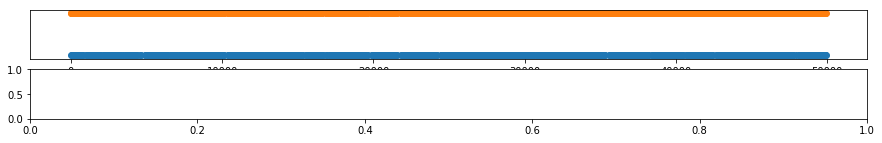

In [18]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

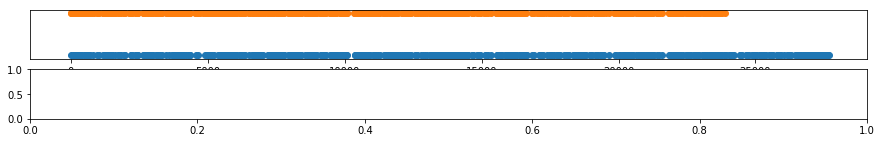

In [19]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

In [20]:
device.reinit()
device.activate()

In [21]:
fits = fitter.generate(params=None, output_var='v',)

exponential_euler


In [22]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [23]:
t

array([   9.3 ,   11.3 ,   84.66,   90.43,  154.27,  177.  ,  205.45,
        265.29,  290.12,  368.55,  411.18,  491.66,  505.18,  517.03,
        581.05,  590.41,  624.94,  686.85,  778.74,  852.71,  967.01,
        973.87, 1029.93, 1178.51, 1180.93, 1199.46, 1276.77, 1313.34,
       1317.56, 1375.26, 1419.51, 1422.86, 1464.15, 1513.24, 1516.42,
       1597.25, 1599.88, 1715.99, 1743.05, 1814.31, 1941.65, 1958.32,
       1984.86, 2123.84, 2175.69, 2179.77, 2197.45, 2217.44, 2344.52,
       2416.83, 2421.28, 2426.74, 2435.21, 2647.85, 2683.25, 2686.58,
       2790.2 , 2810.61, 2818.78, 2858.55, 2885.47, 2921.7 , 2975.39,
       2986.6 ])

In [24]:
os = array(out_spikes[0])
os[os<3000]

array([  10.85,   86.77,  152.87,  177.99,  206.49,  255.46,  289.97,
        351.57,  372.45,  411.88,  501.64,  514.26,  569.2 ,  588.26,
        617.37,  659.91,  705.57,  796.7 ,  968.93, 1029.32, 1179.85,
       1201.26, 1277.75, 1314.76, 1374.47, 1408.51, 1422.03, 1462.08,
       1485.98, 1514.33, 1597.82, 1717.75, 1744.83, 1814.92, 1943.69,
       1985.12, 2178.47, 2198.5 , 2217.57, 2345.9 , 2418.41, 2427.14,
       2450.77, 2650.41, 2686.33, 2729.71, 2792.29, 2818.29, 2859.09,
       2884.83, 2922.46, 2975.51, 2988.59])

In [25]:
v = fits[0]
d = 300000

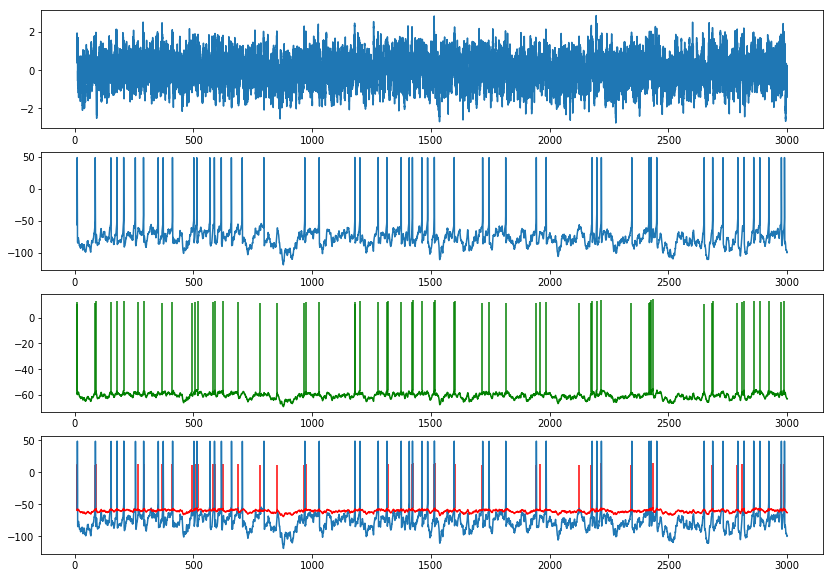

In [26]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'r');


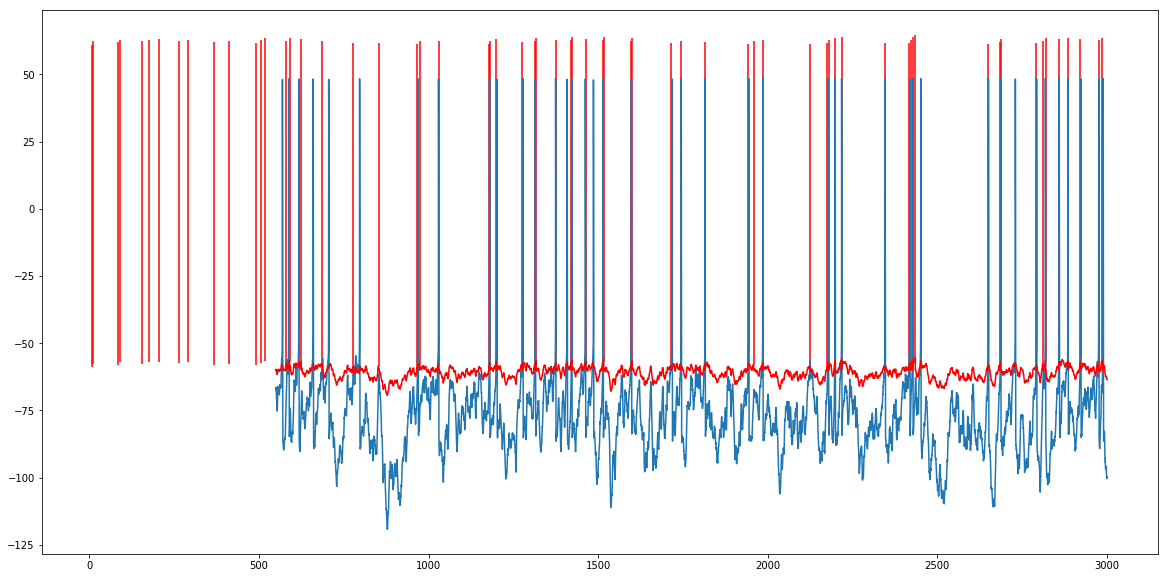

In [27]:
plt.figure(figsize=(20,10))
plot(t0[55000:d]/ms, voltage1[55000:d]);
plot(t0[55000:d]/ms, v[55000:d]-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]+60, v[np.int_(np.round(t/dt*ms))]-60, 'r');
